<a href="https://colab.research.google.com/github/kcalizadeh/phil_nlp/blob/master/w2v.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports and Mounting Drive

In [1]:
# this cell mounts drive, sets the correct directory, then imports all functions
# and relevant libraries via the functions.py file
from google.colab import drive
import sys

# install relevent libraries not included with colab
!pip install lime
!pip install symspellpy

drive.mount('/gdrive',force_remount=True)

drive_path = '/gdrive/MyDrive/Colab_Projects/Phil_NLP'

sys.path.append(drive_path)

     |████████████████████████████████| 276kB 12.2MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp36-none-any.whl size=283846 sha256=3d32d4a7ab445133c5b13d801f11a69a063b967b35c9f71327c5b8acbdacabc0
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime
     |████████████████████████████████| 2.6MB 13.6MB/s 
Mounted at /gdrive


In [2]:
from functions import *
%load_ext autoreload
%autoreload 2

np.random_seed=17

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Load the Data

In [3]:
df = pd.read_csv('/gdrive/MyDrive/Colab_Projects/Phil_NLP/phil_nlp.csv')

df.sample(5)

,title,author,school,sentence_spacy,sentence_str,sentence_length,sentence_lowered,lemmatized_str,tokenized_txt
291113,kapital,Marx,communism,They count merely as depositories of so much a...,They count merely as depositories of so much a...,349,they count merely as depositories of so much a...,-PRON- count merely as depository of so much ...,"['They', 'count', 'merely', 'as', 'depositorie..."
105922,three dialogues,Berkeley,empiricism,But here lies the difference.,But here lies the difference.,29,but here lies the difference.,but here lie the difference .,"['But', 'here', 'lies', 'the', 'difference', '.']"
139680,philosophical investigations,Wittgenstein,analytic,Let us first discuss this point of the argumen...,Let us first discuss this point of the argumen...,105,let us first discuss this point of the argumen...,let -PRON- first discuss this point of the ar...,"['Let', 'us', 'first', 'discuss', 'this', 'poi..."
57671,complete works vol 1,Aristotle,aristotle,"If it thunders while a hen bird is brooding, t...","If it thunders while a hen bird is brooding, t...",65,"if it thunders while a hen bird is brooding, t...","if -PRON- thunder while a hen bird be brood ,...","['If', 'it', 'thunders', 'while', 'a', 'hen', ..."
179999,philosophical troubles,Kripke,analytic,Quine Two Dogmas of Empiricism is no doubt the...,Quine Two Dogmas of Empiricism is no doubt the...,92,quine two dogmas of empiricism is no doubt the...,Quine two Dogmas of empiricism be no doubt th...,"['Quine', 'Two', 'Dogmas', 'of', 'Empiricism',..."


In [4]:
# using gensim's built-in tokenizer 
df['gensim_tokenized'] = df['sentence_str'].map(lambda x: simple_preprocess(x.lower(),deacc=True,
                                                        max_len=100))

In [5]:
# check how it worked
print(df.iloc[216282]['sentence_str'])
df['gensim_tokenized'][216282]

The bumble bee is a part of the reproductive system of the clover.


['the',
 'bumble',
 'bee',
 'is',
 'part',
 'of',
 'the',
 'reproductive',
 'system',
 'of',
 'the',
 'clover']

Well with that beautiful little quote, we are ready to start training our w2v model! At first we'll focus on a single school, since a single school is more likely to have consistency in their use of a word.

Unfortunately, we didn't have much luck with just training on the texts alone. The code for it is left here for posterity, but it was when we worked with GloVe as the base that we had results that were actually useful.

### Word 2 Vec Training

#### German Idealism as a Test Case

We start by examining the texts of German Idealism to get a feel for what kind of parameters would work best.

In [6]:
def make_w2v(series, stopwords=[], size=200, window=5, min_count=5, workers=-1, 
             epochs=20, lowercase=True, sg=0, seed=17, cbow_mean=1, alpha=0.025,
             sample=0.001, use_bigrams=True, threshold=10, bigram_min=5):
  # turn the series into a list, lower it, clean it
    sentences = [sentence for sentence in series]
    if lowercase:
      cleaned = []
      for sentence in sentences:
        cleaned_sentence = [word.lower() for word in sentence]
        cleaned_sentence = [word for word in sentence if word not in stopwords]
        cleaned.append(cleaned_sentence)
    else:
      cleaned = []
      for sentence in sentences:
        cleaned_sentence = [word for word in sentence]
        cleaned_sentence = [word for word in sentence if word not in stopwords]
        cleaned.append(cleaned_sentence)

  # incorporate bigrams
    if use_bigrams:
      bigram = Phrases(cleaned, min_count=bigram_min, threshold=threshold, delimiter=b' ')
      bigram_phraser = Phraser(bigram)
      tokens_list = []
      for sent in cleaned:
        tokens_ = bigram_phraser[sent]
        tokens_list.append(tokens_)
      cleaned = tokens_list
    else:
      cleaned = cleaned

  # build the model
    model = Word2Vec(cleaned, size=size, window=window, 
                     min_count=min_count, workers=workers, seed=seed, sg=sg,
                     cbow_mean=cbow_mean, alpha=alpha, sample=sample)
    model.train(series, total_examples=model.corpus_count, epochs=epochs)
    model_wv = model.wv
    
  # clear it to avoid unwanted transference
    del model

    return model_wv

In [18]:
bigram_gi = make_w2v(df[df['school'] == 'german_idealism']['gensim_tokenized'], threshold=12)

We can check this model by trying out a few words. For that purpose we have a testing function that tries some common word combinations.

In [19]:
pairs_to_try = [(['law', 'moral'], []),
                (['self', 'consciousness'], []),
                (['dialectic'], []),
                (['logic'], []),
]

In [20]:
test_w2v_pos_neg(bigram_gi, pairs_to_try)

Positive - ['law', 'moral']	Negative - []
- briefly (0.22728)
- de (0.226)
- affect (0.21829)
- causal connection (0.21455)
- fanaticism (0.21406)

Positive - ['self', 'consciousness']	Negative - []
- philosophers (0.22425)
- born (0.21982)
- been able (0.21365)
- norm (0.21355)
- transformation (0.21213)

Positive - ['dialectic']	Negative - []
- instituted (0.28496)
- deputies (0.26338)
- alter (0.25104)
- energy (0.25003)
- illustration (0.22995)

Positive - ['logic']	Negative - []
- agreeing (0.24091)
- postulated (0.23968)
- quite different (0.23708)
- organized beings (0.2285)
- superficiality (0.2269)



Although some of these make a modicum of sense a lot of them seem like just gibberish. Let's try messing with some parameters.



In [21]:
bigram_gi.most_similar('self consciousness')

[('common', 0.25377702713012695),
 ('per ception', 0.24532398581504822),
 ('efficacy', 0.22992604970932007),
 ('proclaimed', 0.22748391330242157),
 ('phaenomena', 0.22655561566352844),
 ('immense', 0.22575584053993225),
 ('marked', 0.2227858603000641),
 ('informs', 0.22088894248008728),
 ('entrance', 0.22031810879707336),
 ('fire', 0.2183404564857483)]

In [28]:
from gensim.models import Phrases

from gensim.models.phrases import Phraser

stopwords = []

documents = list(df[df['school'] == 'german_idealism']['gensim_tokenized'])

sentences = [sentence for sentence in documents]
cleaned = []
for sentence in sentences:
  cleaned_sentence = [word.lower() for word in sentence]
  cleaned_sentence = [word for word in sentence if word not in stopwords]
  cleaned.append(cleaned_sentence)


bigram = Phrases(cleaned, min_count=1, threshold=10, delimiter=b' ')

bigram_phraser = Phraser(bigram)

tokens_list = []
for sent in cleaned:
    tokens_ = bigram_phraser[sent]
    tokens_list.append(tokens_)

    # print(tokens_)

In [ ]:
tokens_list[200:300]

In [84]:
model = Word2Vec(tokens_list)
model.train(tokens_list, total_examples=model.corpus_count, epochs=5)
model_wv = model.wv

In [ ]:
len(model_wv.vocab)

In [86]:
model_wv.most_similar('dialectic')

[('antinomy', 0.780921220779419),
 ('paralogism', 0.7721890211105347),
 ('procedure', 0.7603916525840759),
 ('resolution', 0.757012128829956),
 ('critique', 0.7568923234939575),
 ('deduction', 0.7457656860351562),
 ('exposition', 0.7319774031639099),
 ('discipline', 0.7255808115005493),
 ('doctrine', 0.7144776582717896),
 ('method', 0.7082430720329285)]

In [ ]:
for token in model_wv.vocab:
  print(token)

In [29]:
bigram?

In [13]:
# make a base model with the preset parameters
base_model = make_w2v(series = df[df['school'] == 'german_idealism']['gensim_tokenized'], 
                         stopwords=[], seed=20)

len(base_model.vocab)

7363

In [88]:
test_w2v_pos_neg(base_model, pairs_to_try)

Positive - ['law', 'moral']	Negative - []
- posteriori (0.22859)
- wisdom (0.22461)
- youth (0.21371)
- ofa (0.21329)
- originates (0.20798)

Positive - ['self', 'consciousness']	Negative - []
- paradoxical (0.26606)
- rose (0.24617)
- position (0.24103)
- acted (0.23753)
- imply (0.23307)

Positive - ['dialectic']	Negative - []
- cavalieri (0.26471)
- meant (0.23451)
- magnet (0.23212)
- republic (0.22457)
- ofan (0.22394)

Positive - ['logic']	Negative - []
- nothingness (0.23737)
- principal (0.22565)
- indirect (0.22187)
- pretends (0.22135)
- quences (0.2203)



##### Trying Skip-gram instead of C-bow

In [ ]:
# make a base model with the preset parameters
skip_gi_wv = make_w2v_v2(series = df[df['school'] == 'german_idealism']['gensim_tokenized'], 
                         stopwords=[], sg=1, seed=0)

In [ ]:
test_w2v_pos_neg(skip_gi_wv, pairs_to_try)

Positive - ['law', 'moral']	Negative - []
- oriental (0.24547)
- variability (0.24501)
- confirm (0.24019)
- surface (0.23287)
- accepted (0.22953)

Positive - ['self', 'consciousness']	Negative - []
- minate (0.24381)
- imperfection (0.23867)
- interest (0.23587)
- concentrated (0.22921)
- wish (0.22456)

Positive - ['dialectic']	Negative - []
- decreased (0.2668)
- bedeutet (0.23926)
- motive (0.23033)
- discovery (0.22896)
- intuited (0.22755)

Positive - ['logic']	Negative - []
- subtle (0.2726)
- previous (0.26817)
- buta (0.25331)
- skilled (0.24676)
- tongue (0.23751)

Positive - ['form']	Negative - ['content']
- information (0.2566)
- therefore (0.24964)
- plausible (0.24919)
- obstinate (0.2391)
- orders (0.22979)



These seem mildy more sensible. Let's tweak the other parameters.

##### Parameter Testing

In [ ]:
model_v1 = make_w2v_v2(df[df['school'] == 'german_idealism']['gensim_tokenized'],
                       stopwords=[],
                       size=500,
                       window=5,
                       min_count=25,
                       epochs=10,
                       sg=1, 
                       seed=45)

len(model_v1.vocab)

2718

In [ ]:
test_w2v_pos_neg(model_v1, pairs_to_try)

NameError: ignored

Despite tweaking parameters far and wide, it's difficult to get any results that are compellingly sensible. In most cases there are one or two terms in the similarity list that make some sense but others that are just strange or unconnected

#### Trying Another School

In [ ]:
cm_w2v = make_w2v_v2(df[df['school'] == 'communism']['gensim_tokenized'],
                       stopwords=[],
                       size=700,
                       window=10,
                       min_count=10,
                       epochs=25,
                       sg=1, 
                       seed=10)

type(cm_w2v)

TypeError: ignored

In [ ]:
pairs_to_try=[(['material', 'conditions'], []),
              (['worker'], ['owner']),
              (['alienation', 'labor'], []),
              (['capital'], [])]

In [ ]:
test_w2v_pos_neg(cm_w2v, pairs_to_try)

Positive - ['material', 'conditions']	Negative - []
- corruption (0.14189)
- treats (0.12078)
- forth (0.11571)
- loaf (0.11047)
- coming (0.10851)

Positive - ['worker']	Negative - ['owner']
- putting (0.12181)
- subservience (0.12126)
- incorporated (0.11326)
- legal (0.11286)
- under (0.11005)

Positive - ['alienation', 'labor']	Negative - []
- transient (0.12955)
- selection (0.11778)
- regulate (0.11776)
- anarchy (0.11498)
- sum (0.11169)

Positive - ['capital']	Negative - []
- egypt (0.13466)
- obliged (0.13243)
- mode (0.1267)
- ways (0.11922)
- turns (0.11891)



Here the results were similar - a few words that made some sense and plenty that were just odd.  

### Building on top of an Existing Model

We'll import GloVe vectors as w2v, then use those as a base from which to train new vectors that are tuned to our corpus.

In [22]:
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

glove_file = datapath('/gdrive/MyDrive/Colab_Projects/Phil_NLP/glove.6B.50d.txt')
tmp_file = get_tmpfile("test_word2vec.txt")

_ = glove2word2vec(glove_file, tmp_file)

glove_vectors = KeyedVectors.load_word2vec_format(tmp_file)

In [23]:
# check out how GloVe works on our test pairs
test_w2v_pos_neg(glove_vectors, pairs_to_try)

Positive - ['law', 'moral']	Negative - []
- morality (0.82654)
- legal (0.82652)
- laws (0.81529)
- constitutional (0.80616)
- fundamental (0.80217)

Positive - ['self', 'consciousness']	Negative - []
- sense (0.83446)
- mind (0.79755)
- vision (0.78202)
- belief (0.78031)
- life (0.77984)

Positive - ['dialectic']	Negative - []
- hegelian (0.88376)
- dialectical (0.83417)
- dialectics (0.80672)
- materialist (0.77674)
- metaphysics (0.77488)

Positive - ['logic']	Negative - []
- reasoning (0.81405)
- intuitionistic (0.76531)
- concepts (0.75831)
- logical (0.75604)
- theory (0.75026)



Ok these make a lot more sense right from the start. But we want them to be trained on our actual philosophical texts - that way we can see how different thinkers use different words and potentially use the vectors for classification.

So in the cells below we train the existing GloVe model on on the German Idealist texts as a test.

In [45]:
glove_vectors.most_similar('freedom')

[('rights', 0.8569907546043396),
 ('democracy', 0.8209146857261658),
 ('respect', 0.8153771162033081),
 ('freedoms', 0.8151387572288513),
 ('independence', 0.7843738794326782),
 ('equality', 0.7748997211456299),
 ('solidarity', 0.7689430713653564),
 ('dignity', 0.7647867202758789),
 ('conscience', 0.7612083554267883),
 ('movement', 0.7480580806732178)]

In [ ]:
# isolate the relevant school
documents = df[df['school'] == 'german_idealism']['gensim_tokenized']

# get bigrams for that school
stopwords = []

sentences = [sentence for sentence in documents]
cleaned = []
for sentence in sentences:
  cleaned_sentence = [word.lower() for word in sentence]
  cleaned_sentence = [word for word in sentence if word not in stopwords]
  cleaned.append(cleaned_sentence)


bigram = Phrases(cleaned, min_count=20, threshold=10, delimiter=b' ')

bigram_phraser = Phraser(bigram)

tokens_list = []
for sent in cleaned:
    tokens_ = bigram_phraser[sent]
    tokens_list.append(tokens_)

# build a toy model to update with
base_model = Word2Vec(size=300, min_count=1)
base_model.build_vocab(tokens_list)
total_examples = base_model.corpus_count

# add GloVe's vocabulary & weights
base_model.build_vocab([list(glove_vectors.vocab.keys())], update=True)

# train on our data
base_model.train(tokens_list, total_examples=total_examples, epochs=base_model.epochs)
base_model_wv = base_model.wv

In [ ]:
base_model_wv.most_similar(positive=['faculty'])

In [ ]:
test_w2v(base_model_wv, pairs_to_try)

We can immediately see that these make a lot more sense (and the similarity scores are a lot higher). Self-consciousness is commonly associated with freedom in German idealism, logic with metaphysics, and the moral law with universality and the good. This is a massive improvement - these vectors can be fairly said to reflect how german idealists use these terms. Moreover, they are significantly different than the original GloVe model, which indicates that there was real learning going on here.

For comparison, let's check these same terms, but as used by Phenomenologists.

In [69]:
def train_glove(school, glove_vectors, threshold=10, stopwords=[],
                min_count=10):
  # isolate the relevant school
  sentences = df[df['school'] == school]['gensim_tokenized']
  sentences = [sentence for sentence in documents]
  cleaned = []
  for sentence in sentences:
    cleaned_sentence = [word.lower() for word in sentence]
    cleaned_sentence = [word for word in sentence if word not in stopwords]
    cleaned.append(cleaned_sentence)

  bigram = Phrases(cleaned, min_count=min_count, threshold=threshold, delimiter=b' ')
  bigram_phraser = Phraser(bigram)

  bigramed_tokens = []
  for sent in cleaned:
      tokens = bigram_phraser[sent]
      bigramed_tokens.append(tokens)

  # built a toy model to update with
  model = Word2Vec(size=300, min_count=1)
  model.build_vocab(bigramed_tokens)
  total_examples = model.corpus_count

  # add GloVe's vocabulary & weights
  model.build_vocab([list(glove_vectors.vocab.keys())], update=True)

  # train on our data
  model.train(bigramed_tokens, total_examples=total_examples, epochs=model.epochs)
  return model.wv



In [70]:
ph_model = train_glove(school='phenomenologoy', glove_vectors=glove_vectors)

test_w2v(ph_model, pairs_to_try)

Positive - ['law', 'moral']	Negative - []
- con (0.96696)
- universal (0.95497)
- per (0.94912)
- power (0.94234)
- whole (0.94027)

Positive - ['self', 'consciousness']	Negative - []
- self consciousness (0.95071)
- essence (0.94981)
- reality (0.94393)
- purpose (0.94244)
- individuality (0.9378)

Positive - ['dialectic']	Negative - []
- presentation (0.95525)
- community (0.95516)
- synthesis (0.94867)
- development (0.94676)
- division (0.94583)

Positive - ['logic']	Negative - []
- common sense (0.94504)
- taste (0.94017)
- judgement (0.93902)
- metaphysics (0.93571)
- man (0.93381)



In [ ]:
ph_model.most_similar('dasein')

These are substantially different - which is good since the schools are substantially different. They mostly make sense, except for words like 'dialectic' which are rarely used by phenomenologists. The general attitude towards logic as a cold sterilizing force is evident, as is their emphasis on perception and natural life, as compared to the German idealist emphasis on abstractions like universality and freedom (see 'self consciousness'). 

These vectors seem to be an effective tool for revealing word usage between the schools. 

As a final kind of exploration of this method, we'll train w2v models in this way for each school and examine how each of them looks a couple of the same words. 

In [ ]:
w2v_dict = {}

for school in df['school'].unique():
  w2v_dict[school] = train_glove(school, glove_vectors=glove_vectors)
  print(f'{school} completed')

KeyboardInterrupt: ignored

In [ ]:
for school in df['school'].unique():
  print(f'\t{school.upper()}')
  print('----------------------')
  test_w2v(w2v_dict[school], [(['philosophy'], [])])

	PLATO
----------------------
Positive - ['philosophy']	Negative - []
- friendship (0.96654)
- war (0.94734)
- learning (0.9461)
- water (0.94579)
- virtue (0.94529)

	ARISTOTLE
----------------------
Positive - ['philosophy']	Negative - []
- conception (0.90234)
- generation (0.89594)
- respiration (0.87903)
- refrigeration (0.87197)
- locomotion (0.86564)

	EMPIRICISM
----------------------
Positive - ['philosophy']	Negative - []
- religion (0.959)
- morality (0.95895)
- infinity (0.94697)
- mankind (0.94397)
- state (0.93667)

	RATIONALISM
----------------------
Positive - ['philosophy']	Negative - []
- necessity (0.94119)
- physician (0.93936)
- reasoning (0.93735)
- indifference (0.9352)
- aside (0.93257)

	ANALYTIC
----------------------
Positive - ['philosophy']	Negative - []
- science (0.95345)
- logic (0.94979)
- psychology (0.94333)
- speech (0.93447)
- semantics (0.92426)

	CONTINENTAL
----------------------
Positive - ['philosophy']	Negative - []
- criticism (0.97731)
- unr

Interestingly, many of these top words align quite strongly with the school's general attitude towards philosophy. 

The model seems solid - our next step is to train one on the entire corpus for use in classification. We do that, and export it, below.

In [ ]:
# isolate the relevant school
sentences = df['gensim_tokenized']

# built a toy model to update with
model = Word2Vec(size=300, min_count=1)
model.build_vocab(sentences)
total_examples = model.corpus_count

# add GloVe's vocabulary & weights
model.build_vocab([list(glove_vectors.vocab.keys())], update=True)

# train on our data
model.train(sentences, total_examples=total_examples, epochs=model.epochs)
all_text_wv = model.wv

In [ ]:
all_text_wv.save_word2vec_format('/gdrive/MyDrive/Colab_Projects/Phil_NLP/w2v_for_nn2.bin')

In [ ]:
from gensim.models import Phrases
>>>
# Train a bigram detector.
bigram_transformer = Phrases(common_texts)
>>>
# Apply the trained MWE detector to a corpus, using the result to train a Word2vec model.
model = Word2Vec(bigram_transformer[common_texts], min_count=1)

In [ ]:
model_2.intersect_word2vec_format('test_word2vec.txt', binary=False, lockf=1.0)

FileNotFoundError: ignored

In [ ]:
model_2.intersect_word2vec_format

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
test_w2v_pos_neg(vectors, pairs_to_try)

Positive - ['law', 'moral']	Negative - []
- good (0.91925)
- negative (0.9187)
- universal (0.91712)
- fine (0.91255)
- public (0.91191)

Positive - ['self', 'consciousness']	Negative - []
- essence (0.93576)
- freedom (0.91574)
- universality (0.91299)
- quantum (0.9107)
- reflection (0.90237)

Positive - ['dialectic']	Negative - []
- division (0.95115)
- process (0.95111)
- method (0.94972)
- definition (0.94837)
- deduction (0.93935)

Positive - ['logic']	Negative - []
- science (0.93664)
- metaphysics (0.92867)
- teleology (0.92438)
- taste (0.9074)
- theology (0.90333)

Positive - ['form']	Negative - ['content']
- ﬂag (0.54249)
- conducts (0.53321)
- proofloo (0.49985)
- semester (0.4997)
- rsality (0.4979)



In [ ]:
Word2Vec.load('word_vectors.bin')

AttributeError: ignored

In [ ]:
glove_vectors.save('word_vectors.bin')

In [ ]:
new_model = Word2Vec.load(glove_vectors)

AttributeError: ignored

In [ ]:
# get all the words from the german idealist corpus
german_idealist_words = []
for sentence in df[df['school'] == 'german_idealism']['gensim_tokenized']:
  for word in sentence:
    german_idealist_words.append(word)

german_idealist_words = list(set(german_idealist_words))

In [ ]:
glove_vectors.build_vocab([german_idealist_words], update=True)

AttributeError: ignored

In [ ]:
glove_vectors.intersect?

Object `glove_vectors.intersect` not found.


In [ ]:
glove_vectors.train(df[df['school'] == 'german_idealism']['gensim_tokenized'], 
                    min_count=1)

AttributeError: ignored

In [ ]:
glove_file = datapath('/gdrive/MyDrive/Colab_Projects/Phil_NLP/glove.6B.50d.txt')


In [ ]:
vectors = model_2.wv

In [ ]:
test_w2v_pos_neg(glove_vectors, pairs_to_try)

Positive - ['law', 'moral']	Negative - []
- morality (0.82654)
- legal (0.82652)
- laws (0.81529)
- constitutional (0.80616)
- fundamental (0.80217)

Positive - ['self', 'consciousness']	Negative - []
- sense (0.83446)
- mind (0.79755)
- vision (0.78202)
- belief (0.78031)
- life (0.77984)

Positive - ['dialectic']	Negative - []
- hegelian (0.88376)
- dialectical (0.83417)
- dialectics (0.80672)
- materialist (0.77674)
- metaphysics (0.77488)

Positive - ['logic']	Negative - []
- reasoning (0.81405)
- intuitionistic (0.76531)
- concepts (0.75831)
- logical (0.75604)
- theory (0.75026)

Positive - ['form']	Negative - ['content']
- succession (0.60184)
- 13th (0.60066)
- 17th (0.59596)
- 16th (0.58968)
- 18th (0.58704)



In [ ]:
def make_w2v(series, stopwords=None, size=200, window=5, min_count=5, workers=-1, 
             epochs=20, lowercase=True):
    sentences = series.map(word_tokenize)
    if lowercase:
      cleaned_sentences = []
      for sentence in list(sentences):
          cleaned = [x.lower() for x in sentence if x.lower() not in stopwords]
          cleaned_sentences.append(cleaned)
    else:
      cleaned = [word for word in sentences not in stopwords]
      cleaned_sentences.append(cleaned)
    model = Word2Vec(cleaned_sentences, size=size, window=window, 
                     min_count=min_count, workers=workers, seed=17)
    model.train(cleaned_sentences, total_examples=model.corpus_count, epochs=epochs)
    model_wv = model.wv
    del model
    return model_wv

In [ ]:
def make_w2v_v2(series, stopwords=None, size=200, window=5, min_count=5, workers=-1, 
             epochs=20, lowercase=True):
    sentences = [sentence for sentence in series]
    if lowercase:
      cleaned = []
      for sentence in sentences:
        cleaned_sentence = [word.lower() for word in sentence]
        cleaned_sentence = [word for word in sentence if word not in stopwords]
        cleaned.append(cleaned_sentence)
    else:
      cleaned = []
      for sentence in sentences:
        cleaned_sentence = [word for word in sentence]
        cleaned_sentence = [word for word in sentence if word not in stopwords]
        cleaned.append(cleaned_sentence)
    model = Word2Vec(cleaned, size=size, window=window, 
                     min_count=min_count, workers=workers, seed=17)
    model.train(series, total_examples=model.corpus_count, epochs=epochs)
    model_wv = model.wv
    del model
    return model_wv

In [ ]:
gi_wv = make_w2v(df.loc[df['school'] == 'communism']['sentence_str'], 
                 stopwords=[],
                 size=700,
                 epochs=200,
                 window=7,
                 min_count=10, sg=1)

In [ ]:
gi_wv.most_similar('money')

[('vital', 0.12160132080316544),
 ('resort', 0.11713527143001556),
 ('breaking', 0.11627447605133057),
 ('notes', 0.11610057204961777),
 ('creates', 0.11516699194908142),
 ('boys', 0.10976336896419525),
 ('cotton', 0.10716287791728973),
 ('completion', 0.10459037870168686),
 ('wide', 0.10393355041742325),
 ('concerns', 0.10353465378284454)]

In [ ]:
gi_wv = make_w2v(df.loc[df['school'] == 'capitalism']['sentence_str'], 
                 stopwords=[],
                 size=100,
                 epochs=25,
                 window=3,
                 min_count=5)

In [ ]:
gi_wv.most_similar('money')

[('tendency', 0.3689945638179779),
 ('continues', 0.36447644233703613),
 ('before', 0.3537063002586365),
 ('lowered', 0.3263741731643677),
 ('met', 0.3160112202167511),
 ('separately', 0.3103809356689453),
 ('monied', 0.303830087184906),
 ('barrenness', 0.29618436098098755),
 ('speaking', 0.29251614212989807),
 ('vol', 0.286594033241272)]

In [ ]:
pl_wv = make_w2v_v2(df.loc[df['school'] == 'plato']['tokenized'], 
                 stopwords=[],
                 size=50,
                 epochs=25,
                 window=5,
                 min_count=5)

In [ ]:
pl_wv.most_similar('concept')

KeyError: ignored

In [ ]:
model = Word2Vec(list(w2v_data), size=700, window=8, min_count=50, workers=-1, seed=17)

model.train(w2v_data, total_examples=model.corpus_count, epochs=10)

wv = model.wv

In [ ]:
df.loc[df['school'] == 'plato']['sentence_str'].head()

0     What new, Socrates, to make you leave your us...
1    Surely you are not prosecuting anyone before t...
2    The Athenians do not call this a prosecution b...
3                                What is this you say?
4    Someone must have indicted you, for you are no...
Name: sentence_str, dtype: object

In [ ]:
df.loc[df['school'] == 'german_idealism']['sentence_str'].head()

248940    Why this Critiq is titled a critique not of pu...
248941    This Critique is to establish mere that there ...
248942    If it succeeds in this berhaupt I render this ...
248943    because the latter can too often be misread as...
248944    In the few cases where 'as such' is used to tr...
Name: sentence_str, dtype: object

In [ ]:
def most_similar(word, topn=5):
    word = nlp.vocab[str(word)]
    queries = [
        w for w in word.vocab 
        if w.is_lower == word.is_lower and w.prob >= -15 and np.count_nonzero(w.vector)
    ]

    by_similarity = sorted(queries, key=lambda w: word.similarity(w), reverse=True)
    return [(w.lower_,w.similarity(word)) for w in by_similarity[:topn+1] if w.lower_ != word.lower_]

In [ ]:
most_similar('substance')

[('substances', 0.7708152),
 ('alcohol', 0.6000577),
 ('drug', 0.5985114),
 ('drugs', 0.5792217),
 ('chemical', 0.57279444)]

In [ ]:
from sklearn.utils import class_weight

In [ ]:
y = pd.get_dummies(df['school'])
y.head()

,analytic,aristotle,capitalism,communism,continental,empiricism,german_idealism,phenomenology,plato,rationalism
0,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,1,0


In [ ]:
y_classes = y.idxmax(1, skipna=False)
y_classes

0              plato
1              plato
2              plato
3              plato
4              plato
             ...    
327667    capitalism
327668    capitalism
327669    capitalism
327670    capitalism
327671    capitalism
Length: 327672, dtype: object

In [ ]:
from sklearn.preprocessing import LabelEncoder

y_classes = y_train.idxmax(1, skipna=False)

# Instantiate the label encoder
le = LabelEncoder()

# Fit the label encoder to our label series
le.fit(list(y_classes))

# Create integer based labels Series
y_integers = le.transform(list(y_classes))

# Create dict of labels : integer representation
labels_and_integers = dict(zip(y_classes, y_integers))

from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight

class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
sample_weights = compute_sample_weight('balanced', y_integers)

class_weights_dict = dict(zip(le.transform(list(le.classes_)), class_weights))


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df['sentence_str'], df['school'])
y_train = pd.get_dummies(y_train)
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

In [ ]:
class_weights_dict

{0: 0.6119067775509188,
 1: 0.6455997478064415,
 2: 1.7993410455410748,
 3: 1.7998681704994872,
 4: 0.9674592551767577,
 5: 1.6027783212678537,
 6: 0.7702679830747532,
 7: 1.13891000092687,
 8: 0.8537275064267352,
 9: 1.4279721092388147}

In [ ]:
labels_and_integers

{'analytic': 0,
 'aristotle': 1,
 'capitalism': 2,
 'communism': 3,
 'continental': 4,
 'empiricism': 5,
 'german_idealism': 6,
 'phenomenology': 7,
 'plato': 8,
 'rationalism': 9}

In [ ]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence

In [ ]:
y_train = pd.get_dummies(df['school']).values

In [ ]:
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(x_train)
list_tokenized_headlines = tokenizer.texts_to_sequences(x_train)
X_t = sequence.pad_sequences(list_tokenized_headlines, maxlen=420)

In [ ]:
model = Sequential()
embedding_size = 128
model.add(Embedding(len(tokenizer.word_index)+1, embedding_size))
# model.add(glove_vectors.get_keras_embedding())
model.add(LSTM(50, return_sequences=True))
# model.add(Dropout(0.3))
model.add(LSTM(50, return_sequences=False))
# model.add(Dropout(0.5))
# model.add(Dense(50, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [ ]:
history = model.fit(X_t, y_train, epochs=10, batch_size=128, validation_split=0.2, class_weight=class_weights_dict)

Epoch 1/10
1536/1536 [==============================] - 146s 94ms/step - loss: 2.3010 - accuracy: 0.1014 - val_loss: 2.3003 - val_accuracy: 0.0975
Epoch 2/10
1536/1536 [==============================] - 143s 93ms/step - loss: 2.2789 - accuracy: 0.1343 - val_loss: 2.3157 - val_accuracy: 0.1035
Epoch 3/10
1536/1536 [==============================] - 143s 93ms/step - loss: 2.0266 - accuracy: 0.2619 - val_loss: 2.5325 - val_accuracy: 0.0906
Epoch 4/10
1536/1536 [==============================] - 145s 95ms/step - loss: 1.6577 - accuracy: 0.3836 - val_loss: 2.8058 - val_accuracy: 0.0938
Epoch 5/10
1536/1536 [==============================] - 145s 95ms/step - loss: 1.4095 - accuracy: 0.4652 - val_loss: 3.0479 - val_accuracy: 0.0945
Epoch 6/10
1536/1536 [==============================] - 145s 94ms/step - loss: 1.2566 - accuracy: 0.5203 - val_loss: 3.4917 - val_accuracy: 0.0945
Epoch 7/10
1536/1536 [==============================] - 145s 94ms/step - loss: 1.1408 - accuracy: 0.5590 - val_loss: 3

KeyboardInterrupt: ignored

In [ ]:
history_df = pd.DataFrame(history.history)

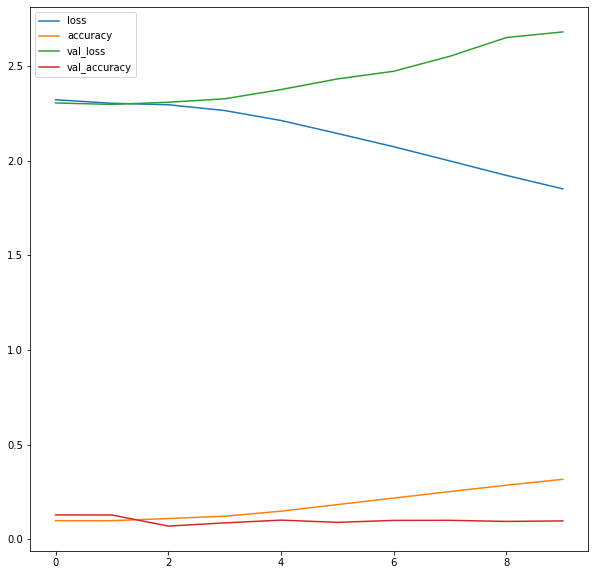

In [ ]:
history_df.plot(figsize=(10,10))

In [ ]:
word_list = ['ness', 'pri', 'al', 'dom', 'te', 'bu', 'er', 'critiq', 'educa', 
             'd', 'dx', 'hen', 'principleb', 'na', 'sensati', 'derstanding',
             'objecti', 'representati', 'sciousness', 'cluding', 'ers', 'simp','jects', 
             'il']

In [ ]:
word_checker = pd.DataFrame()
for word in word_list:
  word_check_slice = df[(df['sentence_lowered'].str.contains('\s'+word+'\s'.lower()))].copy()
  word_check_slice['word'] = word
  word_checker = word_checker.append(word_check_slice)

In [ ]:
len(word_checker)

785

In [ ]:
word_checker['word'].value_counts()

ness           119
al              81
te              76
na              71
pri             69
il              59
er              58
sciousness      54
hen             49
derstanding     24
jects           22
dx              22
principleb      21
bu              19
ers             10
dom              9
sensati          5
educa            5
objecti          5
critiq           3
cluding          2
simp             1
d                1
Name: word, dtype: int64

In [ ]:
word_checker[word_checker['word']=='bu']

,Unnamed: 0,title,author,school,sentence_spacy,sentence_str,sentence_length,sentence_lowered,tokenized,word
162653,184776,quintessence,quine,analytic,a bu the English translation of which has the form 'p and not tJ .,a bu the English translation of which has the form 'p and not tJ .,66,a bu the english translation of which has the form 'p and not tj .,"[a, bu, the, English, translation, of, which, has, the, form, ', p, and, not, tJ, .]",bu
203563,229585,writing and difference,derrida,continental,"I can only, I must only speak to the other; that is, I must call him in the vocative, which is not a category, a case of speech, bu rather the bursting forth, the very raising up of speech.","I can only, I must only speak to the other; that is, I must call him in the vocative, which is not a category, a case of speech, bu rather the bursting forth, the very raising up of speech.",189,"i can only, i must only speak to the other; that is, i must call him in the vocative, which is not a category, a case of speech, bu rather the bursting forth, the very raising up of speech.","[I, can, only, ,, I, must, only, speak, to, the, other, ;, that, is, ,, I, must, call, him, in, the, vocative, ,, which, is, not, a, category, ,, a, case, of, speech, ,, bu, rather, the, bursting, forth, ,, the, very, raising, up, of, speech, .]",bu
206754,232922,writing and difference,derrida,continental,"The Irish and Welsh custom of the wake is little known, bu was Joyce's last work, Finnegan's Wake, Finnegan's funeral vigil (but the reading of this famous novel is at least uneasy).","The Irish and Welsh custom of the wake is little known, bu was Joyce's last work, Finnegan's Wake, Finnegan's funeral vigil (but the reading of this famous novel is at least uneasy).",182,"the irish and welsh custom of the wake is little known, bu was joyce's last work, finnegan's wake, finnegan's funeral vigil (but the reading of this famous novel is at least uneasy).","[The, Irish, and, Welsh, custom, of, the, wake, is, little, known, ,, bu, was, Joyce, 's, last, work, ,, Finnegan, 's, Wake, ,, Finnegan, 's, funeral, vigil, (, but, the, reading, of, this, famous, novel, is, at, least, uneasy, ), .]",bu
279425,310777,the phenomenology of spirit,hegel,german_idealism,"Here thinking, instead of making progress in the transition from Subject to Predicate, in reali ty feels itselfchecked by the loss of the Bu bject, and, missing it, is thrown back on to the thought of the Subject.","Here thinking, instead of making progress in the transition from Subject to Predicate, in reali ty feels itselfchecked by the loss of the Bu bject, and, missing it, is thrown back on to the thought of the Subject.",213,"here thinking, instead of making progress in the transition from subject to predicate, in reali ty feels itselfchecked by the loss of the bu bject, and, missing it, is thrown back on to the thought of the subject.","[Here, thinking, ,, instead, of, making, progress, in, the, transition, from, Subject, to, Predicate, ,, in, reali, ty, feels, itselfchecked, by, the, loss, of, the, Bu, bject, ,, and, ,, missing, it, ,, is, thrown, back, on, to, the, thought, of, the, Subject, .]",bu
279717,311080,the phenomenology of spirit,hegel,german_idealism,"preservingN ow is, therefore, not immediate bu mediated; for it is determined as a permanent and self preserving Now","preservingN ow is, therefore, not immediate bu mediated; for it is determined as a permanent and self preserving Now",116,"preservingn ow is, therefore, not immediate bu mediated; for it is determined as a permanent and self preserving now","[preservingN, ow, is, ,, therefore, ,, not, immediate, bu, mediated, ;, for, it, is, determined, as, a, permanent, and, self, preserving, Now]",bu
280033,311425,the phenomenology of spirit,hegel,german_idealism,"It advances uninterruptedly to the outcome in which all these essential essentialities or determinations are equally set aside; bu in each single momen tit is conscious only of this one det

In [ ]:
fixer_dict = {'\sderstanding': 'understanding',
              '\sject': 'ject',
              '\sjects': 'jects', 
              '\sness': 'ness',
              '\wi\son': 'ion',
              '\spri/sori': 'priori',
              '\sprincipleb': 'principle',
              '\ssciousness': 'sciousness',
              '\stion': 'tion',
              'pri/s': '\spri',
              '\scluding': 'cluding',
              '\sdom': 'dom',
              '\sers': 'ers',
              '\scritiq\s': '\scritique\s'}

SyntaxError: ignored

In [ ]:
def glove2dict(glove_filename):
    with open(glove_filename, encoding='utf-8') as f:
        reader = csv.reader(f, delimiter=' ', quoting=csv.QUOTE_NONE)
        embed = {line[0]: np.array(list(map(float, line[1:])))
                for line in reader}
    return embed

In [ ]:
!pip install mittens
import csv
import numpy as np
from collections import Counter
from nltk.corpus import brown
from mittens import GloVe, Mittens
from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import CountVectorizer

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
glove_path = "/gdrive/MyDrive/Colab_Projects/Phil_NLP/glove.6B.50d.txt" 
pre_glove = glove2dict(glove_path)

In [ ]:
sw = list(stop_words.ENGLISH_STOP_WORDS)

# brown_data = brown.words()[:200000]
# brown_nonstop = [token.lower() for token in brown_data if (token.lower() not in sw)]
# oov = [token for token in brown_nonstop if token not in pre_glove.keys()]a

In [ ]:
nltk.download('punkt')
w2v_data = df['sentence_str'].map(word_tokenize)
w2v_data.sample(10)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


298231    [Hence, a, lessened, demand, for, those, commo...
244696                  [However, ,, this, presentation, .]
195484    [Thus, minority, under, family, tutelage, ,, a...
196485    [The, Meditations, require, such, a, double, r...
88851     [A, certain, admixture, ,, accordingly, ,, of,...
75492     [But, neither, all, things, nor, out, of, cont...
7518      [Well, ,, if, it, depends, on, our, trying, ,,...
254883    [This, purposiveness, of, forms, can, be, call...
242371    [Vhether, this, unity, is, conceived, as, sum,...
203295    [To, possess, ,, to, know, ,, to, grasp, are, ...
Name: sentence_str, dtype: object

In [ ]:
stopwords_list = stopwords.words('english') + list(string.punctuation) + ['“','”','...',"''",'’','``', "'", "‘"]
custom_stopwords = ['–', 'also', 'something', 'cf', 'thus', 'two', 'now', 'would', 'make', 'eb', 'u', 'well', 'even', 'said', 'eg', 'us',
                    'n', 'sein', 'e', 'da', 'therefore', 'however', 'would', 'thing', 'must', 'merely', 'way', 'since', 'latter', 'first',
                    'B', 'mean', 'upon', 'yet', 'cannot', 'c', 'C', 'let', 'may', 'might', "'s", 'b', 'ofthe', 'p.', '_', '-', 'eg', 'e.g.',
                    'ie', 'i.e.', 'f', 'l', "n't", 'e.g', 'i.e', '—', '--', 'hyl', 'phil', 'one', 'press', 'cent', 'place'] + stopwords_list

In [ ]:
word_list = [item for sublist in list(w2v_data) for item in sublist]

In [ ]:
len(word_list)

9759667

In [ ]:
cleaned_words = [x.lower() for x in word_list if x.lower() not in custom_stopwords][:1000000]
# freq_dist = FreqDist(cleaned_words)

In [ ]:
oov = [token for token in cleaned_words if token not in pre_glove.keys()][:1000000]

In [ ]:
def get_rareoov(xdict, val):
    return [k for (k,v) in Counter(xdict).items() if v<=val]

In [ ]:
corp_vocab = list(set(oov))
all_text_doc = [' '.join(cleaned_words)]

In [ ]:
len(corp_vocab)

6295

In [ ]:
cv = CountVectorizer(ngram_range=(1,1), vocabulary=corp_vocab)
X = cv.fit_transform(all_text_doc)
Xc = (X.T * X)
Xc.setdiag(0)
coocc_ar = Xc.toarray()

/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [ ]:
# oov_rare = get_rareoov(oov, 1)
# corp_vocab = list(set(oov) - set(oov_rare))
# tokens = [token for token in cleaned_words if token not in oov_rare]
# # all_text_doc = [' '.join(tokens)]

# corp_vocab = list(set(oov))
# all_text_doc = [' '.join(cleaned_words)]

# cv = CountVectorizer(ngram_range=(1,1), vocabulary=corp_vocab)
# X = cv.fit_transform(all_text_doc)
# Xc = (X.T * X)
# Xc.setdiag(0)
# coocc_ar = Xc.toarray()

mittens_model = Mittens(n=50, max_iter=100)

# new_embeddings = mittens_model.fit(
#     coocc_ar,
#     vocab=corp_vocab,
#     initial_embedding_dict= pre_glove)

In [ ]:
new_embeddings = mittens_model.fit(
    coocc_ar,
    vocab=corp_vocab,
    initial_embedding_dict= pre_glove)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Iteration 100: loss: 14372.193359375

In [ ]:
with open("embeddings.txt", "w") as variable_file:
    variable_file.write(str(new_embeddings))

In [ ]:
newglove = dict(zip(corp_vocab, new_embeddings))
f = open("repo_glove.pkl","wb")
pickle.dump(newglove, f)
f.close()

In [ ]:
embeddings_dict = {}
with open("embeddings.txt", 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

ValueError: ignored

In [ ]:
def find_closest_embeddings(embedding):
    return sorted(embeddings_dict.keys(), key=lambda word: spatial.distance.euclidean(embeddings_dict[word], embedding))

In [ ]:
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

glove_file = datapath('/gdrive/MyDrive/Colab_Projects/Phil_NLP/glove.6B.50d.txt')
tmp_file = get_tmpfile("test_word2vec.txt")

_ = glove2word2vec(glove_file, tmp_file)

glove_vectors = KeyedVectors.load_word2vec_format(tmp_file)

In [ ]:
glove_vectors.most_similar('god')

[('divine', 0.8702991604804993),
 ('heaven', 0.840563178062439),
 ('christ', 0.8195050954818726),
 ('faith', 0.7931702733039856),
 ('allah', 0.7795287370681763),
 ('holy', 0.772378146648407),
 ('sacred', 0.7701617479324341),
 ('true', 0.7637672424316406),
 ('jesus', 0.7632808685302734),
 ('gods', 0.7590562105178833)]

In [ ]:
model.get_keras_embedding()

In [ ]:
w2v_data.head()

0    [What, new, ,, Socrates, ,, to, make, you, lea...
1    [Surely, you, are, not, prosecuting, anyone, b...
2    [The, Athenians, do, not, call, this, a, prose...
3                        [What, is, this, you, say, ?]
4    [Someone, must, have, indicted, you, ,, for, y...
Name: sentence_str, dtype: object

In [ ]:
cleaned_words = [x.lower() for x in all_text_words if x.lower() not in custom_stopwords]
freq_dist = FreqDist(cleaned_words)

In [ ]:
import gensim
# WORD2VEC
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 100
W2V_MIN_COUNT = 2
# Collect corpus for training word embeddings
documents = [tokenize(_text) for _text in np.array(train.summary)]
documents = documents + [tokenize(_text) for _text in np.array(train.title)]
# Train Word Embeddings and save
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, window=W2V_WINDOW,                                                                                  min_count=W2V_MIN_COUNT)
w2v_model.build_vocab(documents)
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)
# Train Word Embeddings
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)
w2v_model.save('embeddings.txt')


NameError: ignored